# Convolutional Network for MNIST Predictions. 
In this notebook, I will be using a convolutional architecture rather than a fully connected network. The architecture I am adopting is LeNet-5, which has recorded an error rate as low as 0.95 (or %99.05 accurate). 

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from collections import OrderedDict

## Custom Dataset Object
Since the dataset provided by Kaggle is not in image format, we can define a custom MNIST dataset object in PyTorch. In the Kaggle dataset, each row of the .csv file represents a single image and its label. The first entry in the row is the image label, while the other 784 entries in the row are the unstacked image pixel values. 

For a convolutional network, we will need to transform those row vectors back into 3D tensors representing actual image data.

In [2]:
class MNIST(Dataset):
    def __init__(self, csv_path, labels=True, transform=None):
        
        self.pixel_frame = pd.read_csv(csv_path)
        self.labels=labels
        self.transform = transform
        self.PIL = transforms.ToPILImage()
        
    
    def __len__(self):
        return len(self.pixel_frame)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
   
        if self.labels:
            label = self.pixel_frame.iloc[index, 0]
            data  = self.pixel_frame.iloc[index, 1:].to_numpy(dtype='float64').reshape(28,28, 1)
            if self.transform:
                data = self.transform(data)
            return data, label
        
        data  = self.pixel_frame.iloc[index].to_numpy(dtype='float64').reshape(28,28)
        if self.transform:
            data = self.transform(data)
        
        return data

## Transforms, Datasets and DataLoaders

Next, we define very basic transforms. First, we transform each 28x28 numpy array into a 1x28x28 torch image tensor. Then we normalize the data to help convergence.

In [3]:
choices = transforms.RandomChoice([transforms.RandomAffine(30),
                                   transforms.RandomPerspective()])

transform = transforms.Compose([#transforms.ToPILImage(),
                                #transforms.RandomApply([choices], 0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = MNIST('data/train.csv', transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)

Next, we define an 80/20 split so that we can estimate our models ability to generalize. From these datasets, we initialize DataLoaders that will automate the process of creating and loading 32 image batches into our model. 

In [4]:
N = len(trainset)
split = (N - int(np.floor(N*.2)), int(np.floor(N*.2)))
trainset, validset = torch.utils.data.random_split(trainset, split)

In [5]:
trainload = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
validload = DataLoader(validset, batch_size=32, shuffle=True, num_workers=4)

Just to make sure that everything is looking good before we get started, let's take a look at a few images:


(torch.float64, torch.Size([1, 28, 28]), torch.Size([32, 1, 28, 28]))

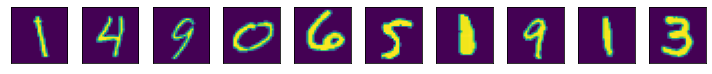

In [6]:
images, labels = iter(trainload).next()

fig, axes = plt.subplots(1, 10, figsize=(10, 15))
for i, im in enumerate(images[:10]):
    axes[i].imshow(im.squeeze())
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout();

images[0].dtype, images[0].shape, images.shape

In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*16, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU()
        )
        
        self.out = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return self.out(x)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet()
model = model.to(device)

In [10]:
opt = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
epochs = 15

train_loss = []
valid_loss = []
accuracy   = []
valid_low = np.Inf

for e in range(epochs):
    running_tl = 0
    running_vl = 0
    running_ac = 0
    
    # backprop and and update
    model.train()
    for images, labels in trainload:
        images, labels = images.to(device), labels.to(device)
        opt.zero_grad()
        t_cel = criterion(model(images.float()), labels)
        t_cel.backward()
        opt.step()

        running_tl += t_cel.item()
        
    with torch.no_grad():
        model.eval()
        for images, labels in validload:
            images, labels = images.to(device), labels.to(device)
            scores = model(images.float())
            ps = F.softmax(scores, dim=1)
            v_cel = criterion(scores, labels)
            pred = torch.argmax(ps, dim=1)
            running_ac += (pred == labels).cpu().numpy().mean()
            running_vl += v_cel.item()

    train_loss.append(running_tl/len(trainload))
    valid_loss.append(running_vl/len(validload))
    accuracy.append(running_ac/len(validload))

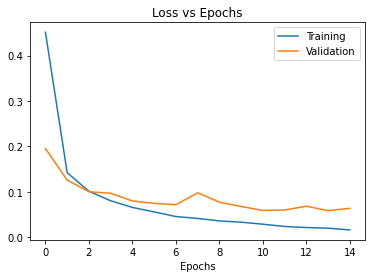

In [11]:
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.plot(train_loss, label='Training')
plt.plot(valid_loss, label='Validation')
plt.legend()

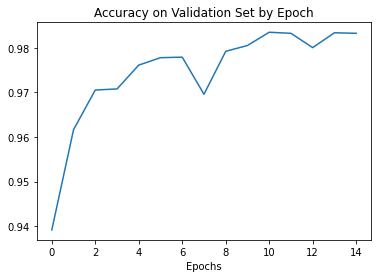

In [12]:
plt.title('Accuracy on Validation Set by Epoch')
plt.xlabel('Epochs')
plt.plot(accuracy)

In [13]:
accuracy[-1]

0.9832461977186312

# Predictions of Kaggle Competition Data:
Now that we have a model that is doing quite well on validation set, let's put it to the test in our competition.

In [14]:
comp_data = pd.read_csv('data/test.csv')
comp_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
unk_set = MNIST('data/test.csv', labels=False)
unk_loader = DataLoader(unk_set, batch_size=32, num_workers=4, shuffle=False)

In [16]:
predictions = np.array([])

for images in unk_loader:
    images = images.to(device).unsqueeze(1).float()
    ps = F.softmax(model(images), dim=1)
    preds = torch.argmax(ps, dim=1).cpu()
    predictions = np.append(predictions, preds)
    

In [17]:
predictions = predictions.astype(np.int)

In [18]:
sub_df = pd.DataFrame(
    {
        'ImageId': np.arange(1, len(predictions) + 1),
        'Label': predictions
    }
)

sub_df.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


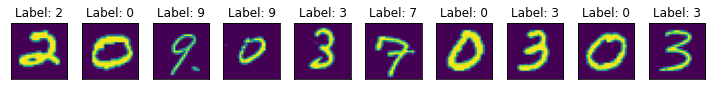

In [19]:
images = iter(unk_loader).next()

fig, axes = plt.subplots(1, 10, figsize=(10,10))

for i in range(10):
    axes[i].set_title(f'Label: {sub_df.loc[i, "Label"]}')
    axes[i].imshow(images[i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()
plt.show()

I see on error... the 4th digit is, in my mind an obvious zero. Looking at the predictions. Let's save as CSV and see how we did, but that's not encouraging.

In [20]:
sub_df.to_csv('submission_LeNet.csv', index=False)